# GROUP-10

TEAM MEMBERS -
1. DHRUV GOEL(23110098)
2. NITIN BANSAL(23110223)

## Section 1

### Task 1

In [1]:
# Import the neccessary libraries
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import pandas as pd
import numpy as np

In [2]:
# Load the Iris dataset
df = load_iris()
x = df.data
y = df.target.reshape(-1, 1)

In [3]:
# One-hot encode the labels
encoder = OneHotEncoder(sparse_output = False)
y_encoded = encoder.fit_transform(y)

In [4]:
# Split into train, validation and test sets in (70%, 10%, 20%)
x_train, x_temp, y_train, y_temp = train_test_split(x, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=2/3, random_state=42, stratify=y_temp)

In [5]:
# Find maximum and minimum of each column for scaling
max_column = x.max(axis = 0)
min_column = x.min(axis = 0)

In [6]:
# Normalize feature values to [0,1] using MinMaxScaler
x_train_scaled = np.zeros([x_train.shape[0],x_train.shape[1]])
x_val_scaled = np.zeros([x_val.shape[0],x_val.shape[1]])
x_test_scaled = np.zeros([x_test.shape[0],x_test.shape[1]])

for i in range(x_train.shape[0]):
  for j in range(4):
    x_train_scaled[i][j] =(x_train[i][j] - min_column[j]) / (max_column[j] - min_column[j])

for i in range(x_val.shape[0]):
  for j in range(4):
    x_val_scaled[i][j] = (x_val[i][j] - min_column[j]) / (max_column[j] - min_column[j])

for i in range(x_test.shape[0]):
  for j in range(4):
    x_test_scaled[i][j] = (x_test[i][j] - min_column[j]) / (max_column[j] - min_column[j])

### Task 2

In [7]:
# Importing required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [8]:
# Define the neural network used in this
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(4, 16)  # Hidden Layer
        self.fc2 = nn.Linear(16, 3)    # Output Layer

    def forward(self, x):
        # Activation function (ReLU)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [9]:
# Converting NumPy arrays to PyTorch tensors
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
x_test_tensor = torch.tensor(x_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Creating DataLoader for batch processing
batch_size = 32
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Task 4

In [10]:
!pip install wandb

In [11]:
# IMporting wandb
import wandb

In [12]:
# Initialize wandb
wandb.login()
wandb.init(project="STT_assignment_6", name="MLP-Training")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: 23110098 (23110098-indian-institute-of-technology-gandhinagar) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [13]:
# Define Hyperparameters
epochs = 500
batch_size = 32
learning_rate = 0.001

# Initializing model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NeuralNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Log Model & Hyperparameters
wandb.config.update({
    "model_architecture": "MLP (4-16-3)",
    "hidden_layer_neurons": 16,
    "activation_function": "ReLU",
    "optimizer": "Adam",
    "learning_rate": learning_rate,
    "batch_size": batch_size,
    "epochs": epochs
})

# Training the model
train_losses = []
val_losses = []
for epoch in range(1,epochs+1):
    model.train()
    total_train_loss = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_outputs = model(x_val)
            val_loss = criterion(val_outputs, y_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    # Log to wandb
    wandb.log({
        "epoch": epoch,
        "train_loss": avg_train_loss,
        "val_loss": avg_val_loss
    })

    # Display results after every 5 epoches
    if (epoch % 5 ==0):
      print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Evaluate the model for test
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predicted = torch.argmax(outputs, dim=1)  # Get class index
        y_pred.extend(predicted.cpu().numpy())
        y_true.extend(torch.argmax(y_batch, dim=1).cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

Epoch 5/500, Train Loss: 1.1356, Val Loss: 1.1271
Epoch 10/500, Train Loss: 1.1028, Val Loss: 1.1038
Epoch 15/500, Train Loss: 1.0773, Val Loss: 1.0830
Epoch 20/500, Train Loss: 1.0705, Val Loss: 1.0598
Epoch 25/500, Train Loss: 1.0331, Val Loss: 1.0325
Epoch 30/500, Train Loss: 0.9849, Val Loss: 1.0024
Epoch 35/500, Train Loss: 0.9685, Val Loss: 0.9714
Epoch 40/500, Train Loss: 0.9396, Val Loss: 0.9406
Epoch 45/500, Train Loss: 0.9027, Val Loss: 0.9088
Epoch 50/500, Train Loss: 0.8512, Val Loss: 0.8760
Epoch 55/500, Train Loss: 0.8144, Val Loss: 0.8428
Epoch 60/500, Train Loss: 0.7874, Val Loss: 0.8111
Epoch 65/500, Train Loss: 0.7608, Val Loss: 0.7811
Epoch 70/500, Train Loss: 0.7272, Val Loss: 0.7511
Epoch 75/500, Train Loss: 0.6934, Val Loss: 0.7227
Epoch 80/500, Train Loss: 0.6809, Val Loss: 0.6958
Epoch 85/500, Train Loss: 0.6583, Val Loss: 0.6713
Epoch 90/500, Train Loss: 0.6554, Val Loss: 0.6476
Epoch 95/500, Train Loss: 0.5876, Val Loss: 0.6263
Epoch 100/500, Train Loss: 0.580

### Task 3

In [14]:
# Importing library for the metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Finding accuracy, precision, recall and f1 score for the model
accuracy_percentage=(accuracy_score(y_true,y_pred))*100
precision_percentage=(precision_score(y_true, y_pred, average="weighted"))*100
recall_percentage=(recall_score(y_true,y_pred, average="weighted"))*100
f1_percentage=(f1_score(y_true,y_pred, average="weighted"))*100

print("Stats:")
print(f"Accuracy: {accuracy_percentage:.2f}%")
print(f"Precision: {precision_percentage:.2f}%")
print(f"Recall: {recall_percentage:.2f}%")
print(f"F1 Score: {f1_percentage:.2f}%")

# Logging the metrics to the wandb
wandb.log({"Accuracy": accuracy_percentage/100})
wandb.log({"Precision": precision_percentage/100})
wandb.log({"Recall": recall_percentage/100})
wandb.log({"F1 score": f1_percentage/100})

Stats:
Accuracy: 100.00%
Precision: 100.00%
Recall: 100.00%
F1 Score: 100.00%


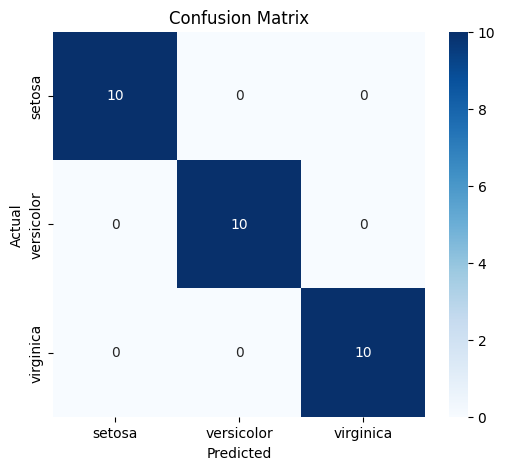

In [15]:
# Import the libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot using heatmap the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=df.target_names, yticklabels=df.target_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
wandb.log({"confusion_matrix": wandb.Image(plt)})
plt.show()


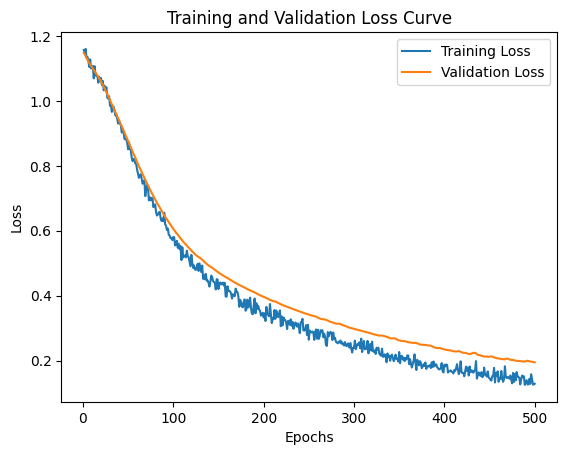

In [16]:
# Plotting the graph of train and validation loss after every epoch
plt.plot(range(1, epochs+1), train_losses, label="Training Loss")
plt.plot(range(1, epochs+1), val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curve")
plt.legend()
wandb.log({"loss_curve": wandb.Image(plt)})
plt.show()

In [ ]:
# Finish the wandb
wandb.finish()

Accuracy,▁
F1 score,▁
Precision,▁
Recall,▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
train_loss,█▇▇▆▆▆▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▆▅▅▅▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
Accuracy,1
F1 score,1
Precision,1
Recall,1


## Section 2

### Task 1

In [ ]:
# Importing neccessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from itertools import product
from sklearn.model_selection import train_test_split
import pandas as pd

In [ ]:
# Define a custom neural network model
class CustomModel(nn.Module):
    def __init__(self):
        super(CustomModel, self).__init__()
        self.fc1 = nn.Linear(4, 32)  # Hidden Layer
        self.fc2 = nn.Linear(32, 3)    # Output Layer

    def forward(self, x):
        # Activation function (ReLU)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Function to train and evaluate the model
def train_and_evaluate(x_train, y_train, x_val, y_val, x_test, y_test, batch_size, learning_rate, epochs):

    # Converting NumPy arrays to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Creating DataLoader for batch processing
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initializing model, loss function, and optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    train_losses = []
    val_losses = []
    for epoch in range(1,epochs+1):
        model.train()
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_outputs = model(x_val)
                val_loss = criterion(val_outputs, y_val)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

    # Evaluate the model on test
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predicted = torch.argmax(outputs, dim=1)  # Get class index
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(torch.argmax(y_batch, dim=1).cpu().numpy())
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    return acc, f1, y_true , y_pred, train_losses, val_losses


For bactch size = 2, learning rate = 0.001, epoches = 1
Accuracy =  0.4666666666666667
F1 score =  0.3675213675213675

 Confusion Matrix


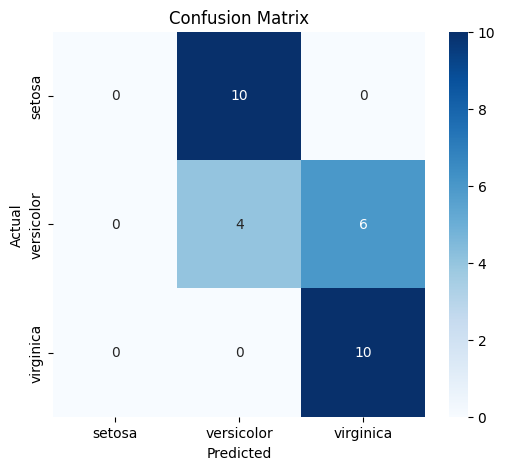

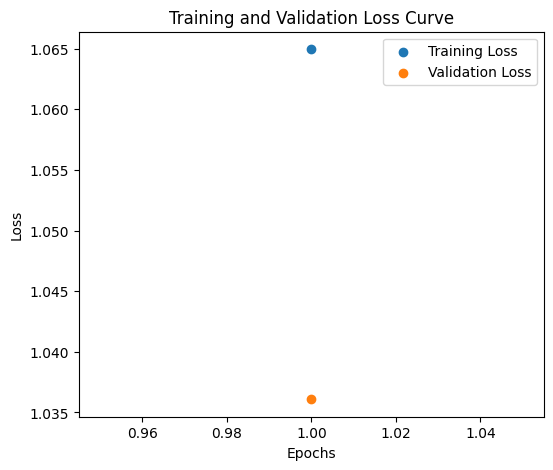


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 1
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 1
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 2, learning rate = 0.001, epoches = 3
Accuracy =  0.6666666666666666
F1 score =  0.5555555555555555

 Confusion Matrix


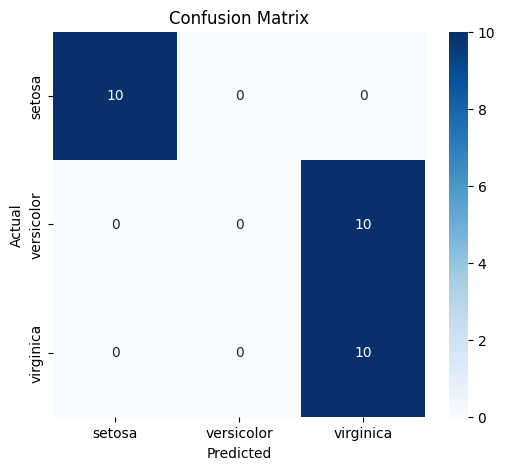

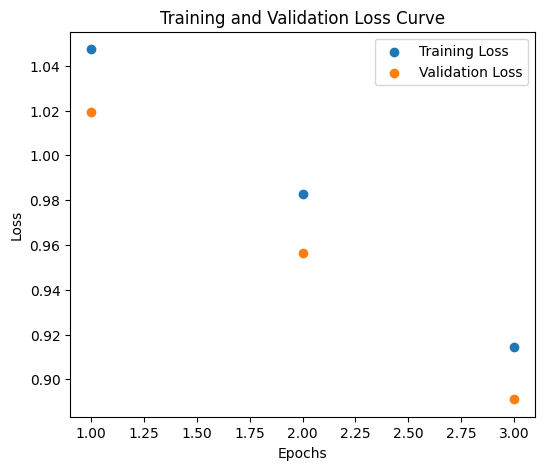


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 2, learning rate = 0.001, epoches = 5
Accuracy =  0.6666666666666666
F1 score =  0.5555555555555555

 Confusion Matrix


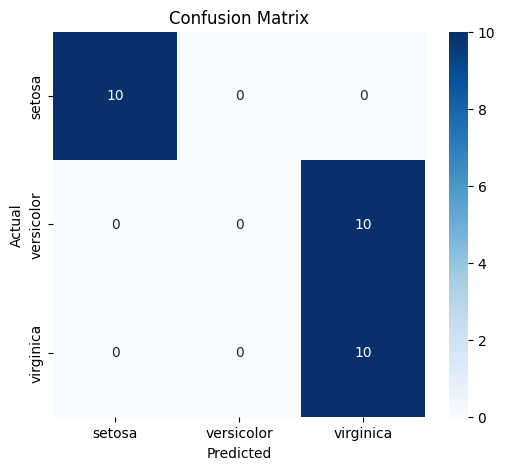

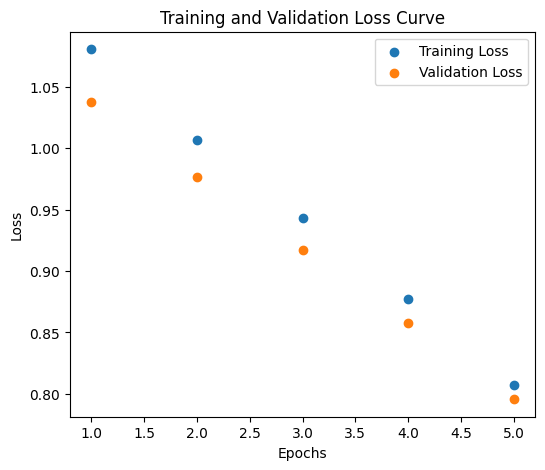


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 2, learning rate = 1e-05, epoches = 1
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


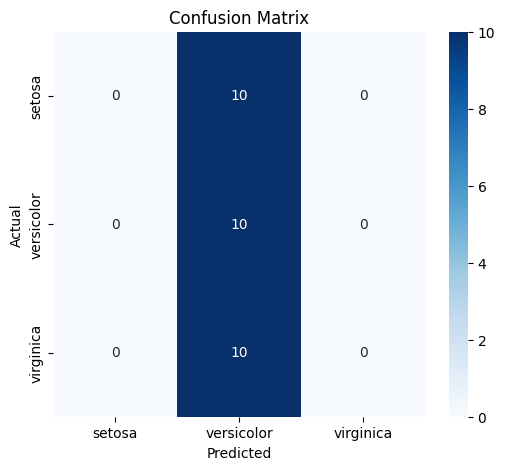

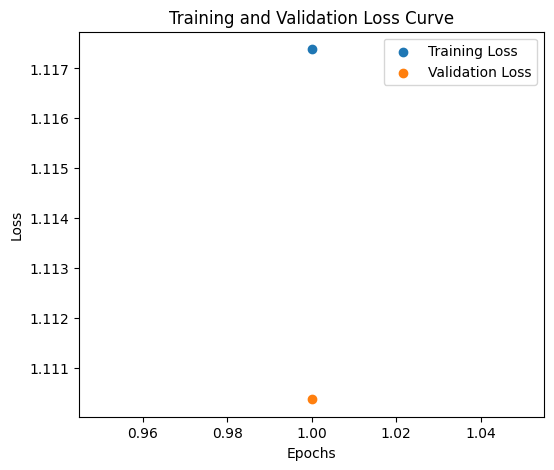


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 1
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 1
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 1

For bactch size = 2, learning rate = 1e-05, epoches = 3
Accuracy =  0.2
F1 score =  0.11764705882352942

 Confusion Matrix


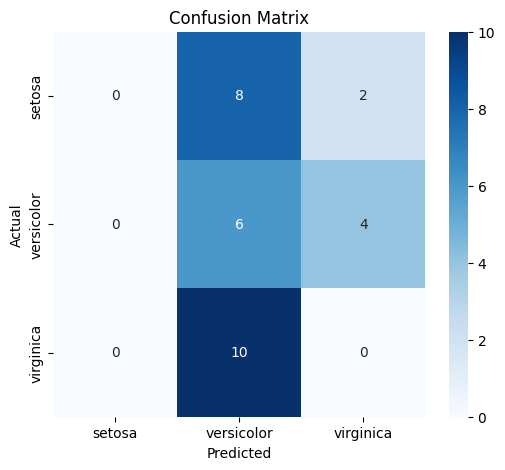

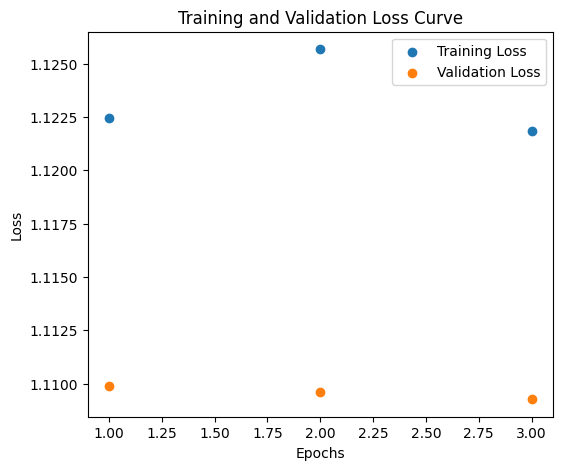


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 1
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 2
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 1

For bactch size = 2, learning rate = 1e-05, epoches = 5
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


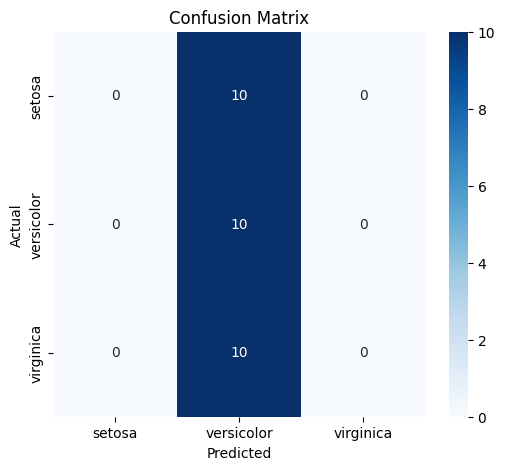

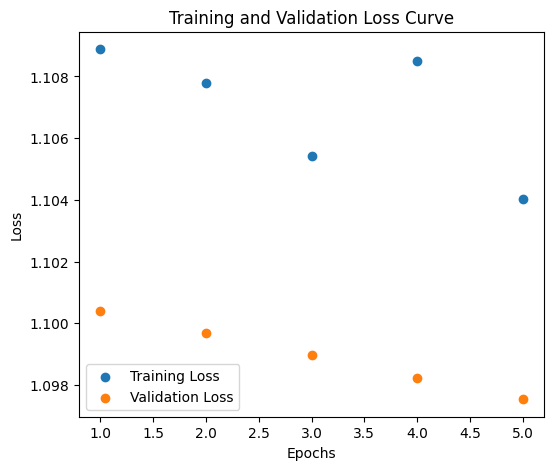


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 1
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 1
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 1

For bactch size = 4, learning rate = 0.001, epoches = 1
Accuracy =  0.6
F1 score =  0.5046296296296297

 Confusion Matrix


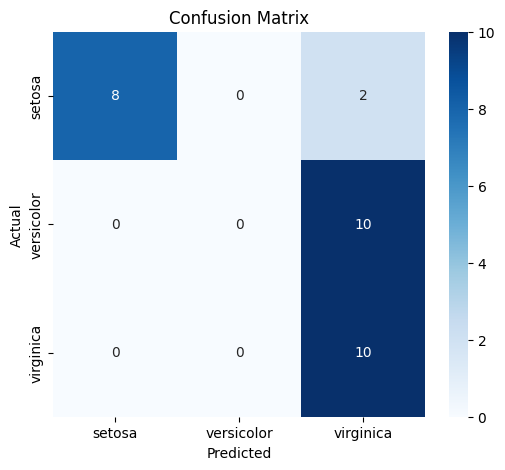

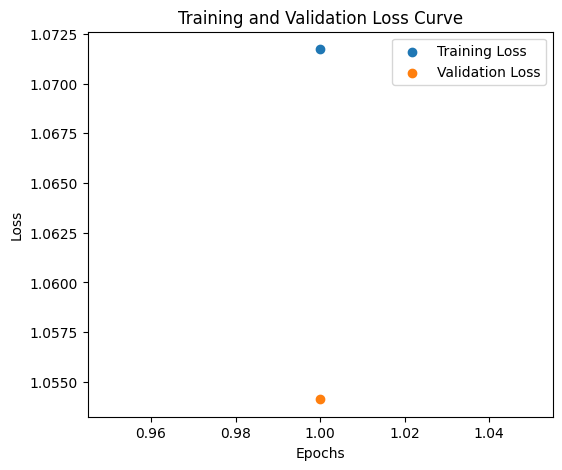


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 4, learning rate = 0.001, epoches = 3
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


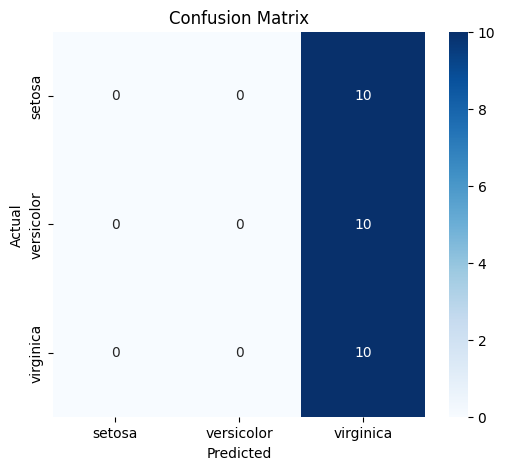

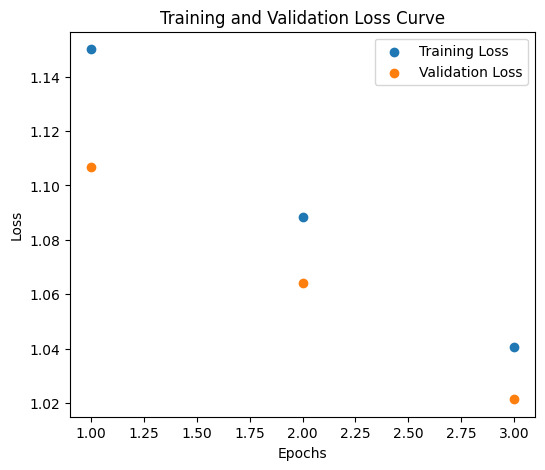


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 2
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 4, learning rate = 0.001, epoches = 5
Accuracy =  0.7
F1 score =  0.6238244514106583

 Confusion Matrix


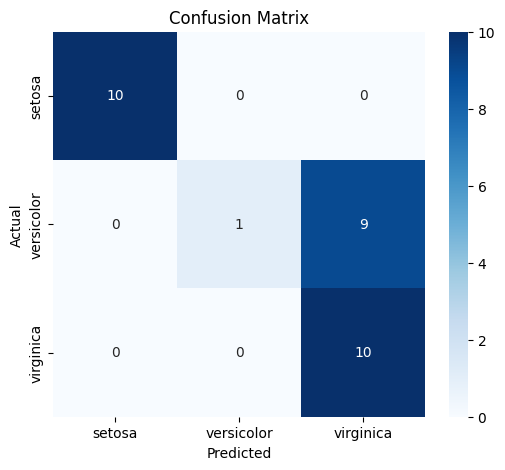

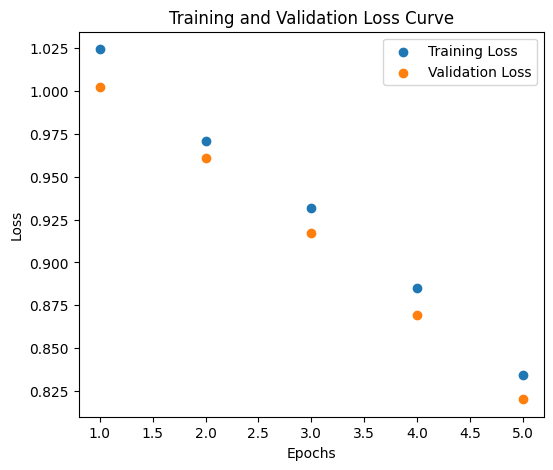


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 0
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 0
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

For bactch size = 4, learning rate = 1e-05, epoches = 1
Accuracy =  0.3333333333333333
F1 score =  0.20202020202020202

 Confusion Matrix


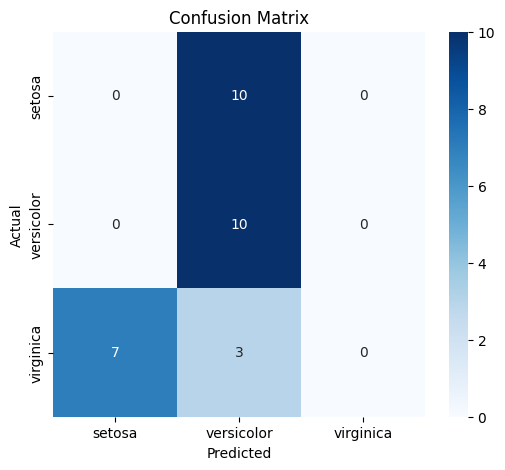

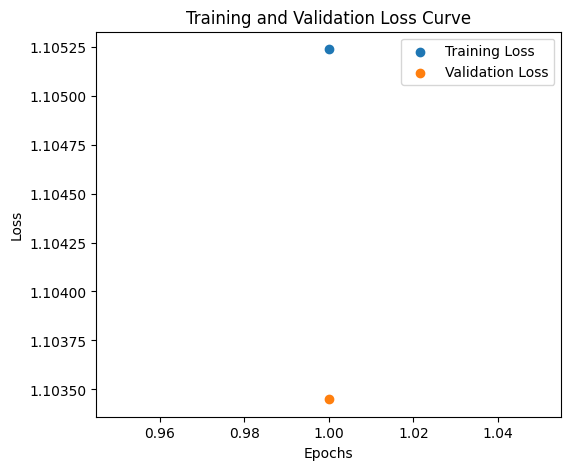


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 0
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 1
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 1
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 0

For bactch size = 4, learning rate = 1e-05, epoches = 3
Accuracy =  0.3333333333333333
F1 score =  0.17094017094017092

 Confusion Matrix


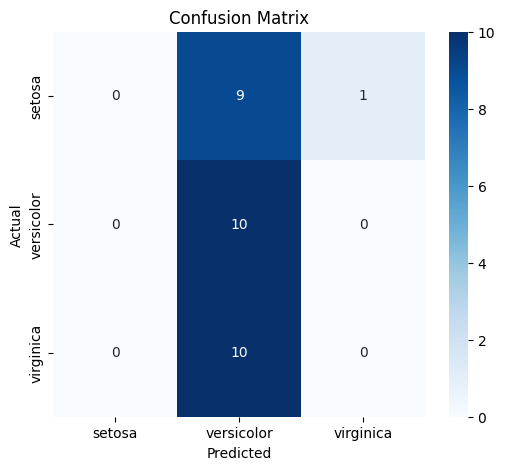

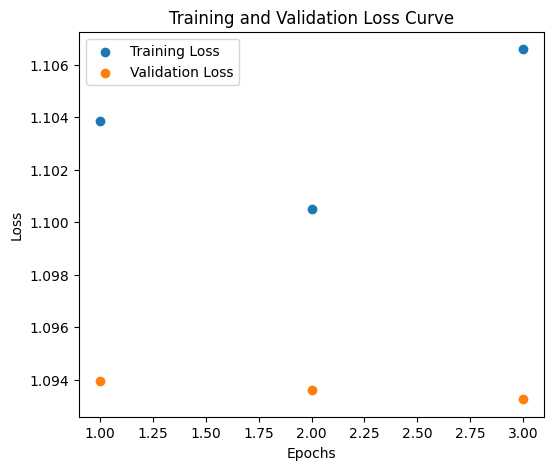


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 1
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 1
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 1
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 1

For bactch size = 4, learning rate = 1e-05, epoches = 5
Accuracy =  0.3333333333333333
F1 score =  0.16666666666666666

 Confusion Matrix


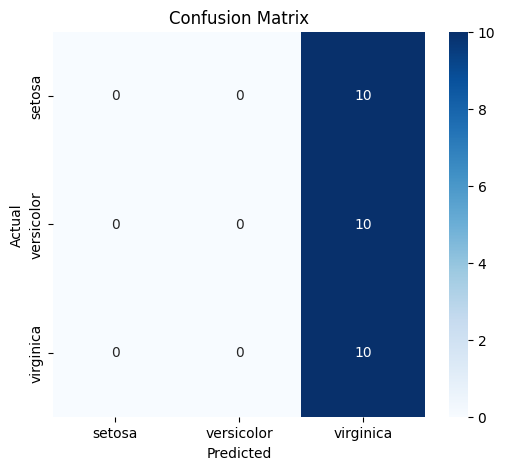

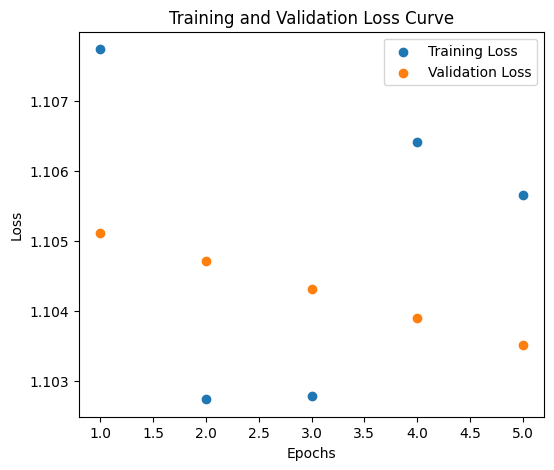


Sample Predictions:
Input: [0.94444444 0.41666667 0.86440678 0.91666667], Truth: 2, Prediction: 2
Input: [0.30555556 0.79166667 0.05084746 0.125     ], Truth: 0, Prediction: 2
Input: [0.02777778 0.41666667 0.05084746 0.04166667], Truth: 0, Prediction: 2
Input: [0.63888889 0.41666667 0.57627119 0.54166667], Truth: 1, Prediction: 2
Input: [0.58333333 0.33333333 0.77966102 0.83333333], Truth: 2, Prediction: 2

Hyperparameter Tuning Results:
    Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0            2        0.00100       1  0.466667  0.367521
1            2        0.00100       3  0.666667  0.555556
2            2        0.00100       5  0.666667  0.555556
3            2        0.00001       1  0.333333  0.166667
4            2        0.00001       3  0.200000  0.117647
5            2        0.00001       5  0.333333  0.166667
6            4        0.00100       1  0.600000  0.504630
7            4        0.00100       3  0.333333  0.166667
8            4        0.00100      

In [ ]:
# Hyperparameters to test
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

# Run experiments for every combination of hyperparameter
results = []
best_f1 = 0
best_acc = 0
best_hyperparams_f1 = {}
best_hyperparams_acc = {}



for batch_size, lr, epochs in product(batch_sizes, learning_rates, epochs_list):
    acc, f1, y_true, y_pred, train_losses, val_losses = train_and_evaluate(x_train_scaled, y_train, x_val_scaled, y_val, x_test_scaled, y_test, batch_size, lr, epochs)
    results.append([batch_size, lr, epochs, acc, f1])

    # Print metrics for every combination of hyperparameter
    print(f"\nFor bactch size = {batch_size}, learning rate = {lr}, epoches = {epochs}")
    print("Accuracy = ",acc)
    print("F1 score = ",f1)

    # Compute confusion matrix for every combination of hyperparameter
    print("\n Confusion Matrix")
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=df.target_names, yticklabels=df.target_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    # Plotting the graph of train and validation loss for every combination of hyperparameter
    plt.figure(figsize=(6,5))
    plt.scatter(range(1, epochs+1), train_losses, label="Training Loss")
    plt.scatter(range(1, epochs+1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Curve")
    plt.legend()
    plt.show()

    # Show 5 sample predictions for every combination of hyperparameter
    print("\nSample Predictions:")
    for i in range(5):
        print(f"Input: {x_test_scaled[i]}, Truth: {y_true[i]}, Prediction: {y_pred[i]}")


    # Track best hyperparameters based on accuracy
    if acc > best_acc:
        best_acc = acc
        best_hyperparams_acc = {"Batch Size": batch_size, "Learning Rate": lr, "Epochs": epochs}

    # Track best hyperparameters based on f1 score
    if f1 > best_f1:
        best_f1 = f1
        best_hyperparams_f1 = {"Batch Size": batch_size, "Learning Rate": lr, "Epochs": epochs}

# Convert results into a DataFrame
results_df = pd.DataFrame(results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])
print("\nHyperparameter Tuning Results:")
print(results_df)

# Display best hyperparameters based on Accuracy
print("\nBest Hyperparameters based on Accuracy:")
print(best_hyperparams_acc)

# Display best hyperparameters based on F1 Score
print("\nBest Hyperparameters based on F1 Score:")
print(best_hyperparams_f1)

From this we can observe that -
1. When the batch size is smaller then the accuracy is more.
2. When the learning rate is more then the accuracy is more.
3. When the number of epoches is more then the accuracy is higher.

Thus we can conclude that accuracy is inversely proportional to batch size and directy proportional to learing rate and number of epoches.

### Task 2

In [ ]:
!pip install scikit-optimize ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize

In [ ]:
# Import the neccessary libraries
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import ParameterGrid, ParameterSampler
from skopt import gp_minimize
from skopt.space import Integer, Real

In [ ]:
# Define search space
param_grid = {
    "batch_size": [2, 4],
    "lr": [1e-3, 1e-5],
    "epochs": [1, 3, 5]
}

In [ ]:
# Placeholder function for training & evaluation
def train_and_evaluate_2(x_train, y_train, x_test, y_test, batch_size, learning_rate, epochs):

    # Converting NumPy arrays to PyTorch tensors
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Converting it to dataloaders for batch processing
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Defing the model, loss function, optimizer
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CustomModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training the model
    for epoch in range(epochs):
        model.train()
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    # Evaluting the model on test
    model.eval()
    y_pred = []
    y_true = []
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch = x_batch.to(device)
            outputs = model(x_batch)
            predicted = torch.argmax(outputs, dim=1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(torch.argmax(y_batch, dim=1).cpu().numpy())

    # Finding accuracy and f1 score
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")

    return acc, f1

In [ ]:
# GRID SEARCH
grid_results = []
for params in ParameterGrid(param_grid):
    acc, f1 = train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, params["batch_size"], params["lr"], params["epochs"])
    grid_results.append((params["batch_size"], params["lr"], params["epochs"], acc, f1))

# Making a dataframe of it
grid_df = pd.DataFrame(grid_results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])

In [ ]:
# RANDOM SEARCH
random_results = []
for params in ParameterSampler(param_grid, n_iter=6, random_state=42):
    acc, f1 = train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, params["batch_size"], params["lr"], params["epochs"])
    random_results.append((params["batch_size"], params["lr"], params["epochs"], acc, f1))

# Making a dataframe of it
random_df = pd.DataFrame(random_results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])

In [ ]:
# BAYESIAN OPTIMIZATION
def objective(params):
    batch_size, lr, epochs = params
    batch_size = int(batch_size)  # Ensure it's an integer
    epochs = int(epochs)  # Ensure it's an integer

    acc, f1 = train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, batch_size, lr, epochs)
    return -f1  # Minimize negative F1-score

# Defing the search space for bayesian
search_space = [
    Integer(2, 4, name="batch_size"),
    Real(1e-5, 1e-3, name="lr"),
    Integer(1, 5, name="epochs")
]

# Minimizing the -f1 score
bayes_result = gp_minimize(objective, search_space, n_calls=12, random_state=42)

bayesian_results = [
    (x[0], x[1], x[2], acc, -y)  # Swap Accuracy and F1 Score order
    for x, y, acc in zip(
        bayes_result.x_iters,
        bayes_result.func_vals,
        [train_and_evaluate_2(x_train_scaled, y_train, x_test_scaled, y_test, int(x[0]), x[1], int(x[2]))[0] for x in bayes_result.x_iters]
    )
]

# Making a dataframe of it
bayesian_df = pd.DataFrame(bayesian_results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1 Score"])

In [ ]:
# COMPARE RESULTS
print("\nGrid Search Results :")
print(grid_df)
print("Max Accuracy :",grid_df['Accuracy'].max())

print("\nRandom Search Results :")
print(random_df)
print("Max Accuracy :",random_df['Accuracy'].max())

print("\nBayesian Optimization Results :")
print(bayesian_df)
print("Max Accuracy :",bayesian_df['Accuracy'].max())

# Combine all results into one table
final_df = pd.concat([
    grid_df.assign(Method="Grid Search"),
    random_df.assign(Method="Random Search"),
    bayesian_df.assign(Method="Bayesian Optimization")
])

print("\nFinal Comparison :")
print(final_df)


Grid Search Results :
    Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0            2        0.00100       1  0.666667  0.555556
1            2        0.00001       1  0.233333  0.126126
2            2        0.00100       3  0.700000  0.656449
3            2        0.00001       3  0.200000  0.148148
4            2        0.00100       5  0.766667  0.734093
5            2        0.00001       5  0.333333  0.166667
6            4        0.00100       1  0.333333  0.166667
7            4        0.00001       1  0.666667  0.547345
8            4        0.00100       3  0.633333  0.530843
9            4        0.00001       3  0.333333  0.166667
10           4        0.00100       5  0.666667  0.555556
11           4        0.00001       5  0.300000  0.157895
Max Accuracy : 0.7666666666666667

Random Search Results :
   Batch Size  Learning Rate  Epochs  Accuracy  F1 Score
0           4        0.00100       5  0.800000  0.780220
1           4        0.00001       3  0.000000  0.

All have the max accuracy something similar but...

On the basis of the above maximum we can say that bayesian is  giving the best accuracy.

And the random and grid are also giving good results.

### Evaluation Criteria

### Perform hyperparameter optimization using AutoGluon

In [ ]:
!pip install autogluon

In [ ]:
from autogluon.tabular import TabularDataset, TabularPredictor
import autogluon.common as agco

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split  # Required for data splitting

# Converting dataset dictionary to a Pandas DataFrame
df1 = pd.DataFrame(df['data'], columns=df['feature_names'])

# Converting target labels to a Pandas Series and name it "target"
target = pd.Series(df['target'], name="target")

# Creating a list of all feature column names and add the target column
targets = df['feature_names'].copy()
targets.append('target')

# Concatenating features and target column into a single DataFrame
df1 = pd.concat([df1, target.to_frame()], axis=1)

# Spliting the dataset into 80% training and 20% testing sets
train_data, test_data = train_test_split(df1, test_size=0.2, random_state=42)

# Saveing training and testing sets as CSV files for AutoGluon compatibility
train_data.to_csv("train.csv", index=False)
test_data.to_csv("test.csv", index=False)

# Loading the data into AutoGluon-compatible TabularDataset format
train_data = TabularDataset("train.csv")
test_data = TabularDataset("test.csv")


Loaded data from: train.csv | Columns = 5 / 5 | Rows = 120 -> 120
Loaded data from: test.csv | Columns = 5 / 5 | Rows = 30 -> 30


In [ ]:
# Step 1: Initializing the AutoGluon Tabular Predictor
predictor = TabularPredictor(
    label='target',
    eval_metric='accuracy',
    path='models/random_model',
    verbosity=2,
    problem_type='multiclass'

# Step 2: Defining Hyperparameter Tuning Configuration
hyperparameter_tune_kwargs = {
    'num_trials': 10,
    'scheduler': 'local',
    'searcher': 'random',
}

# Step 3: Training the Model with Hyperparameter Optimization
predictor.fit(
    train_data,
    hyperparameters={
        'NN_TORCH': {       # Using a neural network model in AutoGluon
            'num_epochs': agco.space.Categorical(1, 3, 5),
            'learning_rate': agco.space.Categorical(1e-3, 1e-5),  # Testing two different learning rates
            'batch_size': agco.space.Categorical(2, 4),  # Testing small batch sizes for their impact
            'activation': 'relu',
            'optimizer': 'adam',
            'hidden_size': 16,
            'num_layers': 1         # Using a single hidden layer
        }
    },
    time_limit=600,
    verbosity=2,
    presets='medium_quality_faster_train',
    raise_on_no_models_fitted=True,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.82 GB / 12.67 GB (77.5%)
Disk Space Avail:   71.17 GB / 107.72 GB (66.1%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/content/models/random_model"
Train Data Rows:    120
Train Data Columns: 4
Label Column:       target
Problem Type:       multiclass
Preprocessing data ...
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    10054.36 MB
	Train Data (Original)  Memory Usage: 0.00 MB (0.0% of available memory)
	Inferri

+--------------------------------------------------------+
| Configuration for experiment     NeuralNetTorch        |
+--------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator |
| Scheduler                        FIFOScheduler         |
| Number of trials                 10                    |
+--------------------------------------------------------+

View detailed results here: /content/models/random_model/models/NeuralNetTorch


Fitted model: NeuralNetTorch/e6a0d_00000 ...
	0.625	 = Validation score   (accuracy)
	8.2s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/e6a0d_00001 ...
	0.1667	 = Validation score   (accuracy)
	8.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/e6a0d_00002 ...
	0.5	 = Validation score   (accuracy)
	8.18s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/e6a0d_00003 ...
	0.7083	 = Validation score   (accuracy)
	8.09s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/e6a0d_00004 ...
	0.7083	 = Validation score   (accuracy)
	8.03s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/e6a0d_00005 ...
	0.0	 = Validation score   (accuracy)
	8.18s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/e6a0d_00006 ...
	0.375	 = Validation score   (accuracy)
	7.93s	 = Training   runtime
	0.01s	 = Validation runtime
F

Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 514.94s of remaining time.
	Ensemble Weights: {'NeuralNetTorch/e6a0d_00003': 1.0}
	0.7083	 = Validation score   (accuracy)
	0.01s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 85.09s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 3382.4 rows/s (24 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/models/random_model")


In [ ]:
import os
import pickle

random_models = {}  # Dictionary to store hyperparameters of different trained models

# Step 1: Iterating over 10 hyperparameter tuning trials
for i in range(10):

    model_path = f'/content/models/random_model/models/NeuralNetTorch/e6a0d_0000{i}'

    # Step 3: Loading each model file and extract relevant hyperparameters
    for file in os.listdir(model_path):
        with open(os.path.join(model_path, file), 'rb') as f:
            model_pkl = pickle.load(f)


            random_models[f'e6a0d_0000{i}'] = (
                model_pkl.params['batch_size'],
                model_pkl.params['learning_rate'],
                model_pkl.params['num_epochs']
            )


In [ ]:
random_models

{'e6a0d_00000': (2, 0.001, 1),
 'e6a0d_00001': (2, 1e-05, 3),
 'e6a0d_00002': (4, 1e-05, 5),
 'e6a0d_00003': (4, 0.001, 3),
 'e6a0d_00004': (4, 0.001, 3),
 'e6a0d_00005': (4, 1e-05, 5),
 'e6a0d_00006': (4, 0.001, 1),
 'e6a0d_00007': (4, 0.001, 5),
 'e6a0d_00008': (2, 1e-05, 1),
 'e6a0d_00009': (4, 1e-05, 3)}

In [ ]:
# Evaluating the model's performance on the test dataset
y_test = test_data['target']
y_pred = predictor.predict(test_data.drop(columns=['target']))

# Printing the accuracy and F1-score to assess model performance
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_pred, average='weighted'):.4f}")

#Generating a leaderboard for the different models tested
leaderboard = predictor.leaderboard(test_data)


Test Accuracy: 0.6667
Test F1: 0.5598


In [ ]:
print("Available keys in random_models:", list(random_models.keys()))


Available keys in random_models: ['e6a0d_00000', 'e6a0d_00001', 'e6a0d_00002', 'e6a0d_00003', 'e6a0d_00004', 'e6a0d_00005', 'e6a0d_00006', 'e6a0d_00007', 'e6a0d_00008', 'e6a0d_00009']


In [ ]:
config_table = []
for _, model_row in leaderboard.iterrows():
    if 'NeuralNetTorch' in model_row['model']:
        # Extracting models using Neural Network (Torch) for comparison.
        # This helps in evaluating how different hyperparameters influence model performance.


        model_preds = predictor.predict(test_data.drop(columns=['target']), model=model_row['model'])


        f1 = f1_score(y_test, model_preds, average='weighted')



        config_table.append({
            'Model': model_row['model'],
            'Accuracy': model_row['score_test'],
            'F1': f1,
            'learning_rate': random_models[model_row['model'].split('/')[1]][1],
            'epochs': random_models[model_row['model'].split('/')[1]][2],
            'batch_size': random_models[model_row['model'].split('/')[1]][0]
        })

# Converting collected results into a DataFrame for easy comparison
config_df = pd.DataFrame(config_table)

# Displaying the final table containing models with their corresponding hyperparameters and performance metrics
print("\nConfiguration Performance Table:")
print(config_df[['Model', 'Accuracy', 'F1', 'learning_rate', 'epochs', 'batch_size']])



Configuration Performance Table:
                        Model  Accuracy        F1  learning_rate  epochs  \
0  NeuralNetTorch/e6a0d_00004  0.666667  0.559829        0.00100       3   
1  NeuralNetTorch/e6a0d_00003  0.666667  0.559829        0.00100       3   
2  NeuralNetTorch/e6a0d_00007  0.666667  0.561460        0.00100       5   
3  NeuralNetTorch/e6a0d_00000  0.600000  0.515556        0.00100       1   
4  NeuralNetTorch/e6a0d_00002  0.466667  0.403030        0.00001       5   
5  NeuralNetTorch/e6a0d_00006  0.333333  0.223077        0.00100       1   
6  NeuralNetTorch/e6a0d_00009  0.200000  0.181212        0.00001       3   
7  NeuralNetTorch/e6a0d_00001  0.200000  0.185714        0.00001       3   
8  NeuralNetTorch/e6a0d_00008  0.033333  0.040000        0.00001       1   
9  NeuralNetTorch/e6a0d_00005  0.000000  0.000000        0.00001       5   

   batch_size  
0           4  
1           4  
2           4  
3           2  
4           4  
5           4  
6           4  
7

In [ ]:
config_df = config_df.drop(columns=['Model'])
config_df


,Accuracy,F1,learning_rate,epochs,batch_size
0,0.666667,0.559829,0.00100,3,4
1,0.666667,0.559829,0.00100,3,4
2,0.666667,0.561460,0.00100,5,4
3,0.600000,0.515556,0.00100,1,2
4,0.466667,0.403030,0.00001,5,4
5,0.333333,0.223077,0.00100,1,4
6,0.200000,0.181212,0.00001,3,4
7,0.200000,0.185714,0.00001,3,2
8,0.033333,0.040000,0.00001,1,2
9,0.000000,0.000000,0.00001,5,4


In [ ]:
# Defining hyperparameter tuning settings
hyperparameter_tune_kwargs = {
    'num_trials': 10,
    'scheduler': 'local',
    'searcher': 'bayes',
}

# Defining the hyperparameter search space
hyperparams = {
    'NN_TORCH': {
        'num_epochs': agco.space.Categorical(1, 3, 5),
        'learning_rate': agco.space.Categorical(1e-3, 1e-5),
        'batch_size': agco.space.Categorical(2, 4),
        'activation': 'relu',
        'optimizer': 'adam',
        'hidden_size': 16,
        'num_layers': 1
    }
}

# Initializing a TabularPredictor for training
predictor = TabularPredictor(
    label='target',
    eval_metric='accuracy',
    path='models/bayesian_model',
    verbosity=2,
)

# Training the model with hyperparameter tuning
predictor.fit(
    train_data,  # Training dataset
    hyperparameters=hyperparams,
    time_limit=600,
    verbosity=2,
    presets='medium_quality_faster_train',
    raise_on_no_models_fitted=True,
    hyperparameter_tune_kwargs=hyperparameter_tune_kwargs
)


Preset alias specified: 'medium_quality_faster_train' maps to 'medium_quality'.
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.11
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Memory Avail:       9.78 GB / 12.67 GB (77.2%)
Disk Space Avail:   71.17 GB / 107.72 GB (66.1%)
Presets specified: ['medium_quality_faster_train']
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "/content/models/bayesian_model"
Train Data Rows:    120
Train Data Columns: 4
Label Column:       target
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	3 unique label values:  [0, 1, 2]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may 

+---------------------------------------------------+
| Configuration for experiment     NeuralNetTorch   |
+---------------------------------------------------+
| Search algorithm                 SearchGenerator  |
| Scheduler                        FIFOScheduler    |
| Number of trials                 10               |
+---------------------------------------------------+

View detailed results here: /content/models/bayesian_model/models/NeuralNetTorch


Fitted model: NeuralNetTorch/377a2f09 ...
	0.625	 = Validation score   (accuracy)
	5.94s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/6d0a8cae ...
	0.375	 = Validation score   (accuracy)
	10.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/5f908003 ...
	0.375	 = Validation score   (accuracy)
	7.15s	 = Training   runtime
	0.02s	 = Validation runtime
Fitted model: NeuralNetTorch/b2789902 ...
	0.0	 = Validation score   (accuracy)
	10.79s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/967b0405 ...
	0.5	 = Validation score   (accuracy)
	7.65s	 = Training   runtime
	0.03s	 = Validation runtime
Fitted model: NeuralNetTorch/d610a0b3 ...
	0.2083	 = Validation score   (accuracy)
	12.61s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralNetTorch/3f0f870b ...
	0.5	 = Validation score   (accuracy)
	10.24s	 = Training   runtime
	0.01s	 = Validation runtime
Fitted model: NeuralN

Fitting model: WeightedEnsemble_L2 ... Training model for up to 360.00s of the 509.76s of remaining time.
	Ensemble Weights: {'NeuralNetTorch/065f9b94': 1.0}
	0.75	 = Validation score   (accuracy)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 90.28s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 3291.3 rows/s (24 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/content/models/bayesian_model")


In [ ]:
import os
import pickle

# Dictionary to store extracted hyperparameters for each Bayesian-trained model
bayesian_models = {}

# Iterating over each folder inside the NeuralNetTorch model directory
for folder in os.listdir('/content/models/bayesian_model/models/NeuralNetTorch'):

    if not os.path.isdir(f'/content/models/bayesian_model/models/NeuralNetTorch/{folder}'):
        continue


    for file in os.listdir(f'/content/models/bayesian_model/models/NeuralNetTorch/{folder}'):

        model_pkl = pickle.load(open(f'/content/models/bayesian_model/models/NeuralNetTorch/{folder}/{file}', 'rb'))

        # Extracting relevant hyperparameters and store them in the dictionary
        bayesian_models[f'{folder}'] = (
            model_pkl.params['batch_size'],
            model_pkl.params['learning_rate'],
            model_pkl.params['num_epochs']
        )


In [ ]:
bayesian_models

{'8bed6de3': (2, 1e-05, 1),
 '377a2f09': (2, 0.001, 1),
 '8689cb80': (4, 0.001, 3),
 '04e34194': (2, 0.001, 5),
 '2ff9c32a': (2, 0.001, 1),
 '3f0f870b': (4, 0.001, 3),
 '23b71b0e': (2, 0.001, 1),
 'cec586b7': (2, 0.001, 1),
 '5060ae4b': (4, 0.001, 5),
 'd5f0f89b': (4, 0.001, 1),
 '7c10efd2': (4, 0.001, 3),
 '967b0405': (2, 0.001, 1),
 'd610a0b3': (2, 1e-05, 5),
 '5f908003': (4, 0.001, 1),
 '678b9550': (4, 1e-05, 1),
 'b2789902': (2, 1e-05, 1),
 '6d0a8cae': (2, 0.001, 1),
 '1ec4724d': (2, 1e-05, 5),
 '5c02e9dc': (4, 0.001, 1),
 '065f9b94': (2, 0.001, 3)}

In [ ]:
# Evaluating model performance on test data
y_test = test_data['target']
y_pred = predictor.predict(test_data.drop(columns=['target']))

# Print evaluation metrics
print(f"Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_pred, average='weighted'):.4f}")

# Getting the leaderboard, which ranks models based on performance on the test data
leaderboard = predictor.leaderboard(test_data)


Test Accuracy: 0.6667
Test F1: 0.5615


In [ ]:
# Initializing an empty list to store model configuration details
config_table2 = []

# Iterating over each row in the leaderboard DataFrame
for _, model_row in leaderboard.iterrows():

    if 'NeuralNetTorch' in model_row['model']:

        model_preds = predictor.predict(test_data.drop(columns=['target']), model=model_row['model'])


        f1 = f1_score(y_test, model_preds, average='weighted')

        # Extracting hyperparameter details from bayesian_models dictionary
        model_key = model_row['model'].split('/')[1]

        # Storing model performance metrics and hyperparameters in a dictionary
        config_table2.append({
            'Model': model_row['model'],
            'Accuracy': model_row['score_test'],
            'F1': f1,
            'learning_rate': bayesian_models[model_key][1],
            'epochs': bayesian_models[model_key][2],
            'batch_size': bayesian_models[model_key][0]
        })

config_df2 = pd.DataFrame(config_table2)


print("\nConfiguration Performance Table:")
config_df2



Configuration Performance Table:


,Model,Accuracy,F1,learning_rate,epochs,batch_size
0,NeuralNetTorch/065f9b94,0.666667,0.561460,0.00100,3,2
1,NeuralNetTorch/377a2f09,0.600000,0.515556,0.00100,1,2
2,NeuralNetTorch/7c10efd2,0.600000,0.537841,0.00100,3,4
3,NeuralNetTorch/3f0f870b,0.600000,0.537841,0.00100,3,4
4,NeuralNetTorch/967b0405,0.500000,0.423030,0.00100,1,2
5,NeuralNetTorch/5f908003,0.400000,0.316410,0.00100,1,4
6,NeuralNetTorch/23b71b0e,0.333333,0.223077,0.00100,1,2
7,NeuralNetTorch/6d0a8cae,0.333333,0.223077,0.00100,1,2
8,NeuralNetTorch/d610a0b3,0.200000,0.181212,0.00001,5,2
9,NeuralNetTorch/b2789902,0.000000,0.000000,0.00001,1,2


In [ ]:
config_df2 = config_df2.drop(columns=['Model'])
config_df2

,Accuracy,F1,learning_rate,epochs,batch_size
0,0.666667,0.561460,0.00100,3,2
1,0.600000,0.515556,0.00100,1,2
2,0.600000,0.537841,0.00100,3,4
3,0.600000,0.537841,0.00100,3,4
4,0.500000,0.423030,0.00100,1,2
5,0.400000,0.316410,0.00100,1,4
6,0.333333,0.223077,0.00100,1,2
7,0.333333,0.223077,0.00100,1,2
8,0.200000,0.181212,0.00001,5,2
9,0.000000,0.000000,0.00001,1,2


In [ ]:
config_df

,Accuracy,F1,learning_rate,epochs,batch_size
0,0.666667,0.559829,0.00100,3,4
1,0.666667,0.559829,0.00100,3,4
2,0.666667,0.561460,0.00100,5,4
3,0.600000,0.515556,0.00100,1,2
4,0.466667,0.403030,0.00001,5,4
5,0.333333,0.223077,0.00100,1,4
6,0.200000,0.181212,0.00001,3,4
7,0.200000,0.185714,0.00001,3,2
8,0.033333,0.040000,0.00001,1,2
9,0.000000,0.000000,0.00001,5,4


In [ ]:
print("Columns in results_df:", results_df.columns)
print("Columns in config_df:", config_df.columns)
print("Columns in config_df2:", config_df2.columns)

Columns in results_df: Index(['batch_size', 'learning_rate', 'epochs', 'Accuracy', 'F1'], dtype='object')
Columns in config_df: Index(['Accuracy', 'F1', 'learning_rate', 'epochs', 'batch_size'], dtype='object')
Columns in config_df2: Index(['Accuracy', 'F1', 'learning_rate', 'epochs', 'batch_size'], dtype='object')


In [ ]:
results_df = results_df.rename(columns={
    "Batch Size": "batch_size",
    "Learning Rate": "learning_rate",
    "Epochs": "epochs",
    "F1 Score": "F1"
})

In [ ]:
# Merge results_df with config_df (random search configurations) on matching hyperparameters
merged_df = results_df.merge(
    config_df,
    on=["learning_rate", "epochs", "batch_size"],
    how="left",
    suffixes=("", "_random")
)

# Merging the newly created merged_df with config_df2 (Bayesian optimization configurations)
merged_df = merged_df.merge(
    config_df2,
    on=["learning_rate", "epochs", "batch_size"],
    how="left",
    suffixes=("", "_bayes")
)

# Renaming columns for better readability and clarity
merged_df = merged_df.rename(columns={
    "Accuracy": "accuracy_random",
    "F1": "f1_random",
    "Accuracy_bayes": "accuracy_bayes",
    "F1_bayes": "f1_bayes"
})


merged_df


,batch_size,learning_rate,epochs,accuracy_random,f1_random,Accuracy_random,F1_random,accuracy_bayes,f1_bayes
0,2,0.00100,1,0.466667,0.367521,0.600000,0.515556,0.600000,0.515556
1,2,0.00100,1,0.466667,0.367521,0.600000,0.515556,0.500000,0.423030
2,2,0.00100,1,0.466667,0.367521,0.600000,0.515556,0.333333,0.223077
3,2,0.00100,1,0.466667,0.367521,0.600000,0.515556,0.333333,0.223077
4,2,0.00100,3,0.666667,0.555556,NaN,NaN,0.666667,0.561460
5,2,0.00100,5,0.666667,0.555556,NaN,NaN,NaN,NaN
6,2,0.00001,1,0.333333,0.166667,0.033333,0.040000,0.000000,0.000000
7,2,0.00001,3,0.200000,0.117647,0.200000,0.185714,NaN,NaN
8,2,0.00001,5,0.333333,0.166667,NaN,NaN,0.200000,0.181212
9,4,0.00100,1,0.600000,0.504630,0.333333,0.223077,0.400000,0.316410
